In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import math


## Importing the data:

In [2]:
polish_data = pd.read_csv(r"C:\Users\chris\OneDrive\MSc\Kalman Filter - Polish Paper\polish_data.csv")
print(polish_data.head())

#ADDING THE 0th State vector
State_zero = pd.DataFrame({'time': 0,"delta_time":0,"X":0,"Y":0, "rot":0, "Vmps":0, "rot_sec":0}, index = [0])
polish_data = pd.concat([State_zero,polish_data]).reset_index(drop = True)

print("\n\n\n",polish_data.head())

   time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0  6062445  4368335  3.8   5.2     0.13
1    11          11  6062500  4368343  5.1   5.2     0.12
2    20           9  6062556  4368351  6.3   5.2    -0.10
3    29           9  6062600  4368359  5.3   5.4     0.35
4    39          10  6062655  4368367  8.8   5.3    -0.12



    time  delta_time        X        Y  rot  Vmps  rot_sec
0     0           0        0        0  0.0   0.0     0.00
1     0           0  6062445  4368335  3.8   5.2     0.13
2    11          11  6062500  4368343  5.1   5.2     0.12
3    20           9  6062556  4368351  6.3   5.2    -0.10
4    29           9  6062600  4368359  5.3   5.4     0.35


## Conversions of values:

In [3]:
def deg_to_rad(deg):
    return deg*np.pi/180

def rad_to_deg(rad):
    return rad*180/np.pi

def rot_min_to_sec(rot_min):
    return rot_min/60

def knots_to_mps(kts):
    return kts*0.51444444

### Getting the epsiloid WGS-84 format:

In [4]:
def e_squared(a,b):
    # a - semi major axis
    # b - semi minor axis
    return (a**2 - b**2)/(a**2)

### Radius of the curvature:

In [5]:
def N_rad_of_curvature(a,e,lat):
    # a - semi-major axis
    # e - square of first eccentric
    # lat - latetude
    N = a/(np.sqrt(1- e*(np.sin(lat)**2)))
    return N

### Cartesian Coordinates

In [6]:
def X_coordinate(N,h,long, lat):
    # N - Curvature of the first vertical circle
    # h - height at point 'P'
    # long - longitude
    # lat - latitude
    return (N+h)*np.cos(long)*np.cos(lat)

def Y_coordinate(N,h,long, lat):
    # N - Curvature of the first vertical circle
    # h - height at point 'P'
    # long - longitude
    # lat - latitude
    return (N+h)*np.cos(long)*np.sin(lat)

def Z_coordinate(N,e,H):
    # N - Curvature of the first vertical circle
    # e - estimate of the squre of the first eccentric
    # H - height at point 'P'
    return (N - (1-e)+H)

## Formulas fo the excelleration in the X and Y axis:

In [146]:
def calc_a_x_y(data_frame, stateNo, deltaTime):
    
    #Vk - speed over ground metre per second
    sog = data_frame.iloc[stateNo,5]
    
    #Course over ground - current state 
    cog = data_frame.iloc[stateNo,4]
    
    #Course over ground - previous state 
    cog_prev = data_frame.iloc[stateNo-1,4]
    
    #Rate of turn - degrees per second
    rot = data_frame.iloc[stateNo,4]
    
    

    top_x = sog*np.cos(deg_to_rad(cog + rot*deltaTime)) - np.cos(deg_to_rad(cog_prev))
    bottom_x = deltaTime
    
    a_x = top_x/bottom_x
    
    top_y = sog*np.sin(deg_to_rad(cog + rot*deltaTime)) - np.sin(deg_to_rad(cog_prev))
    bottom_y = deltaTime
    
    a_y = top_y/bottom_y
    
    return a_x, a_y


In [152]:
a_x, a_y = calc_a_x_y(polish_data,2,1)
print(a_x)
print(a_y)

4.120015693148009
0.8545667492618328


# Kalman filter - Carolina University

In [58]:
#Intitial estiamtes:
X_0 = np.array([[0],[0],[0],[0]])


## State vector $X_k$:

#### **Note the initial state $X_0 = [0,0,0,0]^{T}$ - already prepended to the POLISH DATASET

In [59]:
def get_state_vector_Xk(data_frame, stateNo):

    #X coordinate    
    X_coord = data_frame.iloc[stateNo,2]

    #Y coordinate
    Y_coord = data_frame.iloc[stateNo,3]

    #Vk - speed over ground
    sog = data_frame.iloc[stateNo,5]
    
    #Course over ground
    cog = data_frame.iloc[stateNo,4]
    
    #retunr state
    X_k = np.array([
            [X_coord],
           [Y_coord],
           [sog*np.cos(deg_to_rad(cog))], 
           [sog*np.sin(deg_to_rad(cog))]])
    return X_k
    

In [60]:
print(get_state_vector_Xk(polish_data,1))

[[6.06244500e+06]
 [4.36833500e+06]
 [5.18856764e+00]
 [3.44624282e-01]]


## Calculating the transition matrix A:

In [61]:
def return_mat_A(deltaTime):
    A = np.identity(4)
    A[0,2] = deltaTime
    A[1,3] = deltaTime
    
    return A   

## Calculate process covariance matrix $P_{k-1}$

In [62]:
def get_Pk_prev(sigma_x, sigma_y, sigma_Vx, sigma_Vy):
    setMat =  np.array([
        [sigma_x],
        [sigma_y],
        [sigma_Vx],
        [sigma_Vy]])
    
    covmat = setMat.dot(np.transpose(setMat))
    return covmat

In [63]:
Q = get_Pk_prev(10,10,0.5,0.5)

# Calculatating the noise matrices, $w_k$ and $v_k$ 

### *according to Carolina paper

In [64]:
def w_k_noise(Q):
    return np.random.normal(0, Q, size=(4,1))

def v_k_noise(R):
    return np.random.normal(0, R, size=(4,1))

## Calculating the Predicted state matrix $\hat{x}^{-}_{k}$

In [65]:
def calc_predicted_state_matrix(df_in, stateNo,deltaTime,A,Q):    
    a_x, a_y = calc_a_x_y(df_in, stateNo, deltaTime)
    
    prev_state = get_state_vector_Xk(df_in, stateNo-1)
    
    if(stateNo == 1):
        w_k_prev = np.array([[0],[0],[0],[0]])
    else:
        w_k_prev = w_k_noise(Q)
        
    
    
    A_dot_prev = A.dot(prev_state)
    
    Bu_k = np.array([
        [a_x*deltaTime*deltaTime/2],
        [a_y*deltaTime*deltaTime/2],
        [a_x*deltaTime],
        [a_y*deltaTime]])
    
    return A_dot_prev + Bu_k + w_k_prev
        
    

# TIME UPDATE - PREDICT:

# Predicted state matrix:

In [74]:
A = return_mat_A(10)
pred_state_mat = calc_predicted_state_matrix(polish_data,2,10,A,Q)
print(pred_state_mat)

[[6.06249420e+06]
 [4.36825688e+06]
 [4.76800281e+00]
 [4.38503576e+00]]


## Project error covariance

In [75]:
def error_covariance(A,Pk_prev,Q):
    return (A.dot(Pk_prev)).dot(np.transpose(A)) + Q

In [76]:
#Q ~~ P_k_1
P_k = error_covariance(A,Q,Q)
print(P_k)

[[325.  325.   12.5  12.5]
 [325.  325.   12.5  12.5]
 [ 12.5  12.5   0.5   0.5]
 [ 12.5  12.5   0.5   0.5]]


# Measurement Update


## Kalman Gain $K_k$ :

In [77]:
def get_Kalman_gain(P_k):
    R = np.diag(np.diag(P_k))
    H = np.identity(4)
    
    return (P_k.dot(np.transpose(H))).dot(  np.linalg.inv(H.dot(P_k).dot(np.transpose(H))  +R ))
    

In [78]:
Kalman_gain = get_Kalman_gain(P_k)
print(Kalman_gain)

[[0.20895522 0.20895522 4.85074627 4.85074627]
 [0.20895522 0.20895522 4.85074627 4.85074627]
 [0.00746269 0.00746269 0.20895522 0.20895522]
 [0.00746269 0.00746269 0.20895522 0.20895522]]


# Update Estimate $\hat{x}_k = \hat{x}_{k}^{-} + ...$

In [80]:
Updated_estimate = pred_state_mat + Kalman_gain.dot(get_state_vector_Xk(polish_data,2) - np.identity(4).dot(pred_state_mat))

print(Updated_estimate)


[[6.06249637e+06]
 [4.36825906e+06]
 [4.72027481e+00]
 [4.33730776e+00]]


In [72]:
get_state_vector_Xk(polish_data,1)

array([[6.06244500e+06],
       [4.36833500e+06],
       [5.18856764e+00],
       [3.44624282e-01]])

# Iterative TEST 1:

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

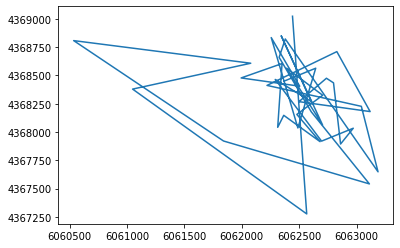

In [106]:
A = return_mat_A(10)
Q = get_Pk_prev(10,10,0.5,0.5)
H = np.identity(4)




error_cov = Q
save_states = []

#Time update
for i in range(0,38):
    pred_state_mat = calc_predicted_state_matrix(polish_data,2,10,A,Q)
    P_k = error_covariance(A,error_cov,Q)

    #Correction update


    Kalman_gain = get_Kalman_gain(P_k)
    Updated_estimate = pred_state_mat + Kalman_gain.dot(get_state_vector_Xk(polish_data,2) - np.identity(4).dot(pred_state_mat))
    save_states.append(Updated_estimate)
    
    error_cov = (np.identity(4) - Kalman_gain.dot(H)).dot(error_cov)
    Q = P_k

#print(save_states)

x = []
y = []
for k in range(0,38):
    temp_state = save_states[k]
    
    x.append(save_states[k][0][0])
    y.append(save_states[k][1][0])
    
    
plt.plot((x),(y))
plt.plot

In [107]:
calc_a_x_y(polish_data, 1, 11)

(0.23984085187904555, 0.33775072128096156)

In [139]:
A = return_mat_A(10)
Q = get_Pk_prev(10,10,0.5,0.5)
H = np.identity(4)

pred_state_mat = calc_predicted_state_matrix(polish_data,8,10,A,Q)
P_k = error_covariance(A,error_cov,Q)

    #Correction update


Kalman_gain = get_Kalman_gain(P_k)
Updated_estimate = pred_state_mat + Kalman_gain.dot(get_state_vector_Xk(polish_data,9) - np.identity(4).dot(pred_state_mat))
save_states.append(Updated_estimate)

error_cov = (np.identity(4) - Kalman_gain.dot(H)).dot(error_cov)
Q = P_k

print(Updated_estimate)

[[6.06281377e+06]
 [4.36843672e+06]
 [1.41675197e+01]
 [1.38963114e+01]]
